In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import json
import cv2
import os
import tensorflow as tf
import tensorflow.keras.layers as tkl
from tensorflow.keras.layers import Conv2D, Input, Dense, MaxPooling2D, Dropout,Conv2DTranspose, Concatenate
import zipfile
from pycocotools.coco import COCO

In [2]:
with zipfile.ZipFile('/content/brain tumer.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
train_anot_dir = '/content/train/_annotations.coco.json'
test_anot_dir = '/content/test/_annotations.coco.json'
val_anot_dir = '/content/valid/_annotations.coco.json'

In [4]:
train_anotated = COCO(train_anot_dir)
test_anotated = COCO(test_anot_dir)
val_anotated = COCO(val_anot_dir)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [5]:
train_anotated.cats

{0: {'id': 0, 'name': 'Tumor', 'supercategory': 'none'},
 1: {'id': 1, 'name': '0', 'supercategory': 'Tumor'},
 2: {'id': 2, 'name': '1', 'supercategory': 'Tumor'}}

In [6]:
def coco_convert(coco_anot, img_dir, output_dir,file_type='jpg'):
  os.makedirs(output_dir, exist_ok=True)
  #image ids
  image_ids = coco_anot.getImgIds()
  # category_colors = {
  #       cat['id']: np.random.randint(0, 256, 3).tolist()
  #       for cat in coco_anot.loadCats(coco_anot.getCatIds())
  # }
  color=[255,0,0]
  for image_id in image_ids:
    image_info = coco_anot.loadImgs(image_id)[0]
    file_name = os.path.splitext(image_info['file_name'])[0]
    image_path = os.path.join(img_dir, image_info.get('file_name'))
    image = cv2.imread(image_path)
    width,height = image_info['width'], image_info['height']
    mask = np.zeros((height,width,3),dtype=np.uint8)

    #annotation ids
    ann_ids = coco_anot.getAnnIds(imgIds=image_id)
    anns = coco_anot.loadAnns(ann_ids)

    for ann in anns:
      for seg in ann['segmentation']:
        pts = np.array(seg).reshape((-1, 2)).astype(np.int32)
        cv2.fillPoly(mask, [pts],color)

    cv2.imwrite(os.path.join(output_dir, f"{file_name}_mask.{file_type}"), mask)





In [7]:
coco_convert(train_anotated, '/content/train', '/content/train_mask')
coco_convert(test_anotated, '/content/test', '/content/test_mask')
coco_convert(val_anotated, '/content/valid', '/content/val_mask')

<h1>This method of loading and normalizing image was inefficent<h1>

Right here,my notebook crashed when I tried normalizing big dataset though loop because of limited RAM, so I would be using more optimized method

In [8]:
# def load_image(image_dir):
#   image=[]
#   for image_name in os.listdir(image_dir):
#     if image_name.endswith('.jpg'):
#       image_path = os.path.join(image_dir, image_name)
#       image.append(imageio.imread(image_path))
#   return image
# train_image = load_image('/content/train')
# test_image = load_image('/content/test')
# val_image = load_image('/content/valid')

In [9]:
# plt.imshow(train_image[0])

In [10]:
# train_mask = load_image('/content/train_mask')
# test_mask = load_image('/content/test_mask')
# val_mask = load_image('/content/val_mask')

In [11]:
# fig = plt.figure(figsize=(10,10))
# plt.subplot(1,2,1)
# plt.imshow(train_image[2])
# plt.subplot(1,2,2)
# plt.imshow(train_mask[2])

In [12]:
# train_mask[0].shape

Optimized loading and preprocess through tensor

In [13]:
def process(image_dir,mask_dir):
  image = tf.io.read_file(image_dir)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (256,256))
  image = tf.cast(image, tf.float32)

  mask = tf.io.read_file(mask_dir)
  mask = tf.image.decode_jpeg(mask, channels=3)
  mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
  mask = tf.image.resize(mask, (256,256))
  mask = tf.where(mask > 0, 1, 0)
  mask = tf.cast(mask, tf.float32)
  return image,mask

In [14]:
train_img_path = sorted(tf.io.gfile.glob('/content/train/*.jpg'))
train_mask_path = sorted(tf.io.gfile.glob('/content/train_mask/*.jpg'))
val_img_path = sorted(tf.io.gfile.glob('/content/valid/*.jpg'))
val_mask_path = sorted(tf.io.gfile.glob('/content/val_mask/*.jpg'))
test_img_path = sorted(tf.io.gfile.glob('/content/test/*.jpg'))
test_mask_path = sorted(tf.io.gfile.glob('/content/test_mask/*.jpg'))

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_img_path, train_mask_path))
val_dataset = tf.data.Dataset.from_tensor_slices((val_img_path, val_mask_path))
test_dataset = tf.data.Dataset.from_tensor_slices((test_img_path, test_mask_path))

In [16]:
def prepare_dataset(dataset):
    return (dataset
            .map(process, num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .batch(10)
            .prefetch(buffer_size=tf.data.AUTOTUNE))

def preprocess(image,mask):
  image = tf.image.resize(image, (256,256))
  mask = tf.image.resize(mask, (256,256))
  return image,mask

In [17]:
train_dataset = prepare_dataset(train_dataset)
val_dataset = prepare_dataset(val_dataset)
test_dataset = prepare_dataset(test_dataset)

In [18]:
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [19]:
#checking the shape of both mask and image
for img, mask in train_dataset.take(1):
    print("Image shape:", img[0].shape)
    print("Mask shape:", mask[0].shape)


Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)


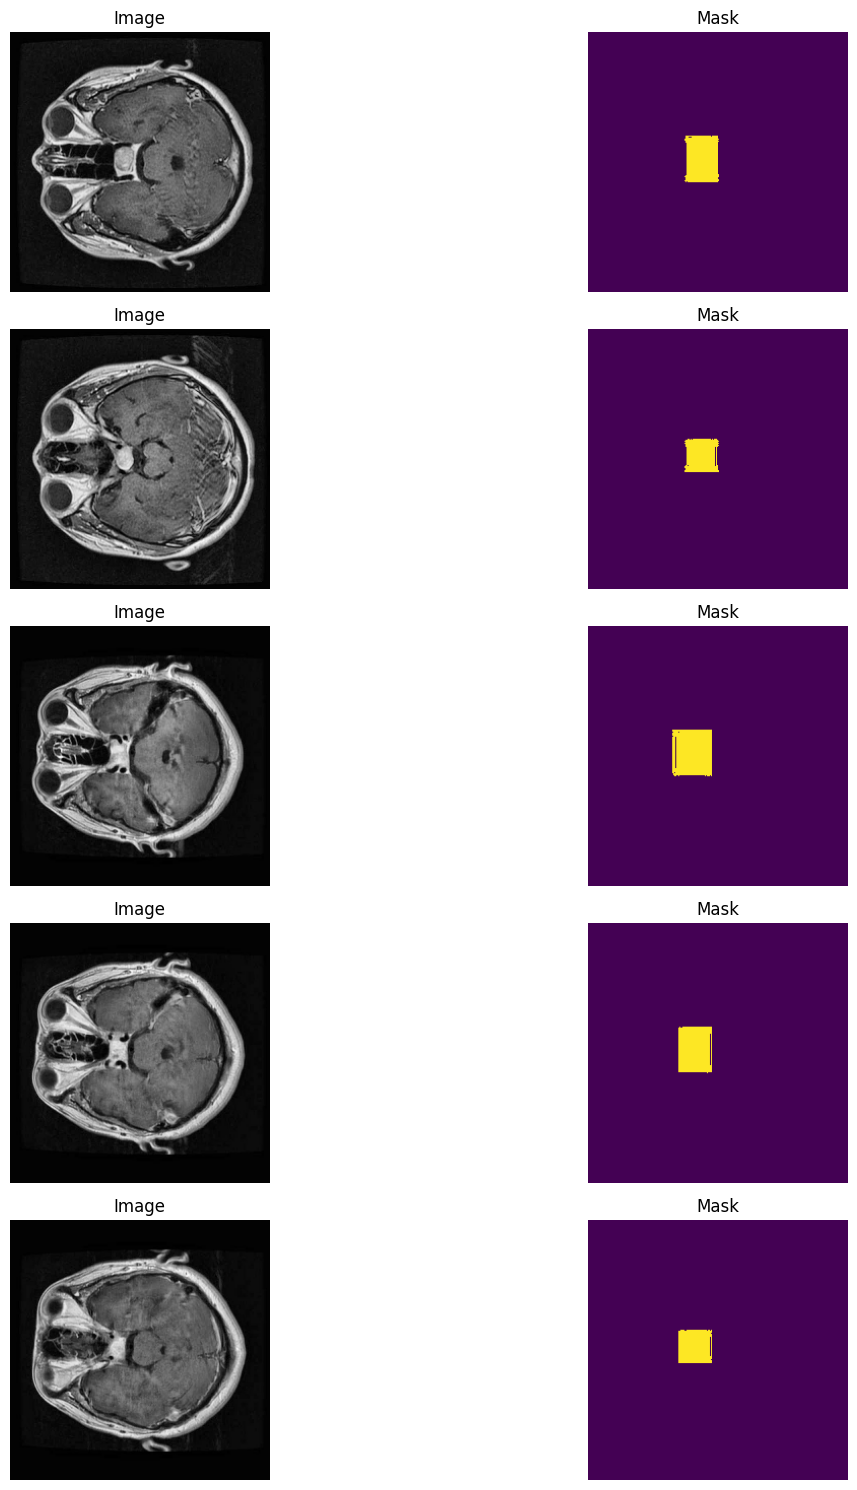

In [20]:
for images, masks in train_dataset.take(1):
    plt.figure(figsize=(15, 15))
    for i in range(5):  # Show first 5 pairs
        # Image
        plt.subplot(5, 2, 2*i + 1)
        plt.imshow(tf.cast(images[i], tf.uint8))
        plt.title("Image")
        plt.axis("off")

        # Mask
        plt.subplot(5, 2, 2*i + 2)
        plt.imshow(tf.cast(masks[i],tf.uint8))  # Remove channel dimension if needed
        plt.title("Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

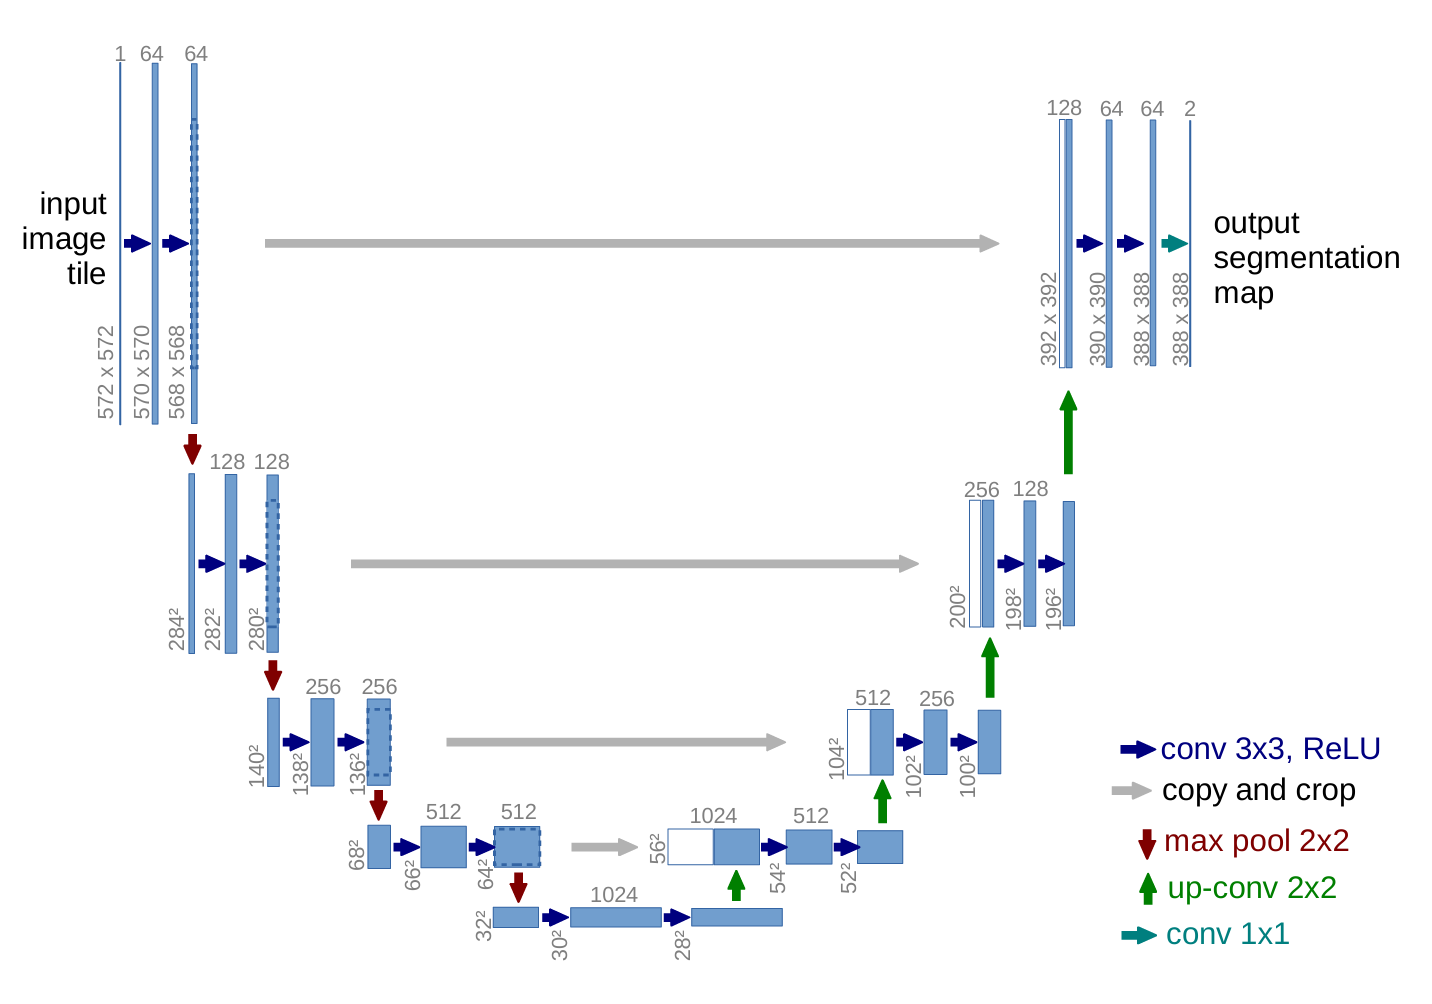

In [21]:
def downsampling(input=None,dropout=0,max_pooling=True,filters=32):

  conv = Conv2D(filters=filters,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(input)
  conv = Conv2D(filters=filters,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(conv)
  #dropout
  if dropout>0:
    conv = Dropout(dropout)(conv)
  #pooling
  if max_pooling:
    next_layer = MaxPooling2D(pool_size=(2,2))(conv)
  else:
    next_layer = conv
  skip_connection = conv
  return next_layer, skip_connection

In [22]:
def upsampling(expansive_input=None,contractive_input=None,filters=32):
  #convtranspose layer
  up = Conv2DTranspose(filters=filters,kernel_size=(3,3),strides=(2,2),padding='same')(expansive_input)
  #combining with skip connection
  merge = Concatenate()([up,contractive_input])
  #conv layer
  conv = Conv2D(filters=filters,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(merge)
  conv = Conv2D(filters=filters,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(conv)

  return merge


In [23]:
def u_net(input=(256,256,3),filter=32,n_class=1):
  inputs = Input(input)
  #downsampling
  cblock1 = downsampling(inputs,filters=filter)
  cblock2 = downsampling(cblock1[0],filters=filter*2)
  cblock3 = downsampling(cblock2[0],filters=filter*4)
  cblock4 = downsampling(cblock3[0],filters=filter*8)
  cblock5 = downsampling(cblock4[0],filters=filter*16)
  cblock6 = downsampling(cblock5[0],filters=filter*32,dropout=0.3,max_pooling=False)
  #upsampling
  dblock1 = upsampling(cblock6[0],cblock5[1],filters=filter*8)
  dblock2 = upsampling(dblock1,cblock4[1],filters=filter*4)
  dblock3 = upsampling(dblock2,cblock3[1],filters=filter*2)
  dblock4 = upsampling(dblock3,cblock2[1],filters=filter)
  dblock5 = upsampling(dblock4,cblock1[1],filters=filter)

  #conv
  conv10 = Conv2D(filters=filter,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(dblock5)
  conv11 = Conv2D(filters=n_class,kernel_size=(1,1),activation='sigmoid')(conv10)
  model = tf.keras.Model(inputs=inputs,outputs=conv11)
  return model

In [24]:
u_net = u_net(input=(256,256,3))
u_net.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 8, 8, 512) │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_4[

 Total params: 22,437,217 (85.59 MB)

 Trainable params: 22,437,217 (85.59 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
#num of image in train
print(len(os.listdir('/content/train')))

1503


In [26]:
u_net.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
#caching and prefetching dataset for more optimized training
train_dataset = train_dataset.cache().shuffle(100).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(100).prefetch(tf.data.AUTOTUNE)

In [28]:
history= u_net.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
    )

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


151/151 ━━━━━━━━━━━━━━━━━━━━ 80s 322ms/step - accuracy: 0.8856 - loss: 4.2728 - val_accuracy: 0.9524 - val_loss: 0.1629
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.9569 - loss: 0.1464 - val_accuracy: 0.9532 - val_loss: 0.1585
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - accuracy: 0.9526 - loss: 0.1518 - val_accuracy: 0.9532 - val_loss: 0.1293
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 0.9556 - loss: 0.1268 - val_accuracy: 0.9532 - val_loss: 0.1271
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 157ms/step - accuracy: 0.9567 - loss: 0.1170 - val_accuracy: 0.9536 - val_loss: 0.1266
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.9571 - loss: 0.1189 - val_accuracy: 0.9534 - val_loss: 0.1239
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 157ms/step - accuracy: 0.9584 - loss: 0.1106 - val_accuracy: 0.9560 - val_loss: 0.1133
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 157ms/step - accuracy: 0.9601 - loss: 0.1055 - val

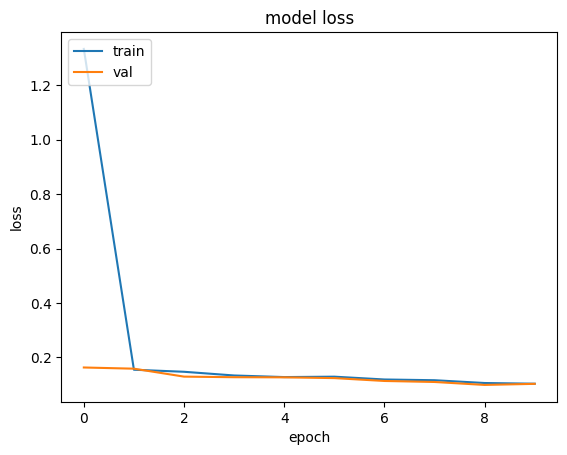

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

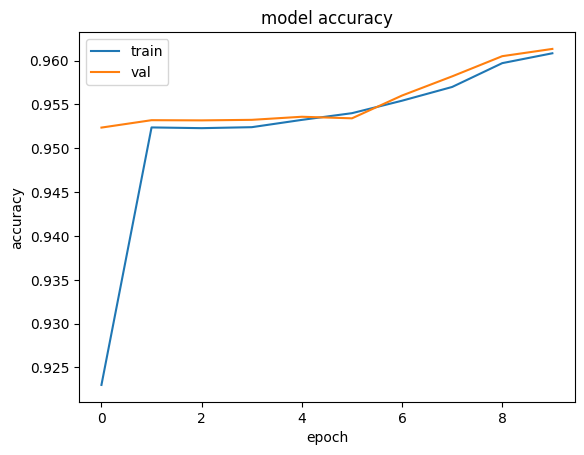

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
model_metrics = u_net.evaluate(test_dataset)

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 360ms/step - accuracy: 0.9713 - loss: 0.0816


In [36]:
print("Loss = ", model_metrics[0])
print("Accuracy = ", model_metrics[1])

Loss =  0.10506559163331985
Accuracy =  0.9596919417381287


In [37]:
u_net.save('Brain_tumor.h5')